In [1]:
import torch 
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_moons

from helper_functions import accuracy_fn, plot_decision_boundary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Text(0.5, 1.0, 'Make Moons Dataset')

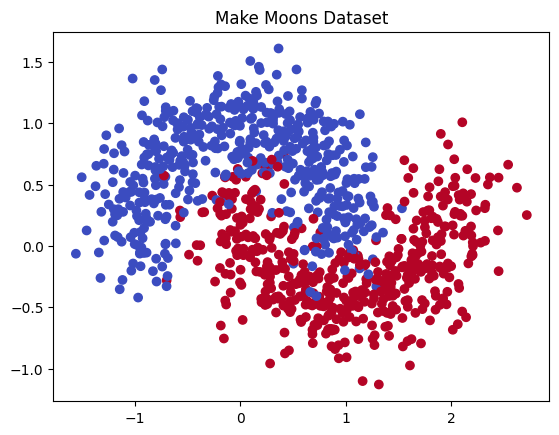

In [3]:
X, y = make_moons(n_samples=1000, random_state=42, noise=0.25)

plt.scatter(x=X[:,0], y=X[:,1],c=y, cmap="coolwarm")
plt.title("Make Moons Dataset")

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.1418,  0.5582],
         [ 1.1980, -0.3040],
         [ 0.7594,  0.1103],
         [ 0.0233, -0.6036],
         [-0.8080,  0.5485]]),
 tensor([1., 1., 1., 1., 0.]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [6]:
class MoonModel(nn.Module):
    def __init__(self): 
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        z = self.relu(self.layer1(X))
        z = self.relu(self.layer2(z))
        return self.layer3(z)

    

In [7]:
model_0 = MoonModel().to(device)
model_0

MoonModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.03)

In [9]:
torch.manual_seed(57)

train_accuracy_list = []
test_accuracy_list = []

train_precision_list = []
test_precision_list = []

train_recall_list = []
test_recall_list = []

train_loss_list = []
test_loss_list = []

epoch_counts = []

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = criterion(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    precision = precision_score(
        y_true=y_train.detach().cpu().numpy(),
        y_pred=y_preds.detach().cpu().numpy())
    recall = recall_score(
        y_true=y_train.detach().cpu().numpy(),
        y_pred=y_preds.detach().cpu().numpy())



    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))

        test_loss = criterion(y_test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)
        
        test_precision = precision_score(
            y_true=y_test.detach().cpu().numpy(),
            y_pred=y_test_preds.detach().cpu().numpy())
        test_recall = recall_score(
            y_true=y_test.detach().cpu().numpy(),
            y_pred=y_test_preds.detach().cpu().numpy())



    if epoch % 10 == 0:
        train_loss_list.append(loss.cpu().item())
        test_loss_list.append(test_loss.cpu().item())

        epoch_counts.append(epoch)

        train_accuracy_list.append(acc)
        test_accuracy_list.append(test_acc)
        
        train_precision_list.append(precision)
        test_precision_list.append(test_precision)
        train_recall_list.append(recall)
        test_recall_list.append(test_recall)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 0 | Loss: 0.71611, Accuracy: 51.12% | Test Loss: 0.72426, Test Accuracy: 45.50%
Epoch: 10 | Loss: 0.70840, Accuracy: 51.12% | Test Loss: 0.71534, Test Accuracy: 45.50%
Epoch: 20 | Loss: 0.70186, Accuracy: 51.12% | Test Loss: 0.70787, Test Accuracy: 45.50%


c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 30 | Loss: 0.69621, Accuracy: 51.12% | Test Loss: 0.70154, Test Accuracy: 45.50%
Epoch: 40 | Loss: 0.69110, Accuracy: 51.12% | Test Loss: 0.69590, Test Accuracy: 45.50%


c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 50 | Loss: 0.68623, Accuracy: 51.12% | Test Loss: 0.69071, Test Accuracy: 45.50%
Epoch: 60 | Loss: 0.68146, Accuracy: 51.12% | Test Loss: 0.68579, Test Accuracy: 45.50%
Epoch: 70 | Loss: 0.67676, Accuracy: 51.12% | Test Loss: 0.68102, Test Accuracy: 45.50%


c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 80 | Loss: 0.67209, Accuracy: 51.12% | Test Loss: 0.67645, Test Accuracy: 45.50%
Epoch: 90 | Loss: 0.66725, Accuracy: 58.63% | Test Loss: 0.67191, Test Accuracy: 56.00%
Epoch: 100 | Loss: 0.66218, Accuracy: 67.62% | Test Loss: 0.66727, Test Accuracy: 67.00%
Epoch: 110 | Loss: 0.65680, Accuracy: 72.25% | Test Loss: 0.66242, Test Accuracy: 72.00%
Epoch: 120 | Loss: 0.65099, Accuracy: 76.12% | Test Loss: 0.65723, Test Accuracy: 74.50%
Epoch: 130 | Loss: 0.64469, Accuracy: 78.25% | Test Loss: 0.65160, Test Accuracy: 77.00%
Epoch: 140 | Loss: 0.63781, Accuracy: 79.25% | Test Loss: 0.64548, Test Accuracy: 78.00%
Epoch: 150 | Loss: 0.63031, Accuracy: 80.25% | Test Loss: 0.63880, Test Accuracy: 78.50%
Epoch: 160 | Loss: 0.62215, Accuracy: 81.62% | Test Loss: 0.63157, Test Accuracy: 78.50%
Epoch: 170 | Loss: 0.61329, Accuracy: 82.00% | Test Loss: 0.62374, Test Accuracy: 79.00%
Epoch: 180 | Loss: 0.60372, Accuracy: 82.00% | Test Loss: 0.61527, Test Accuracy: 79.00%
Epoch: 190 | Loss: 0.59

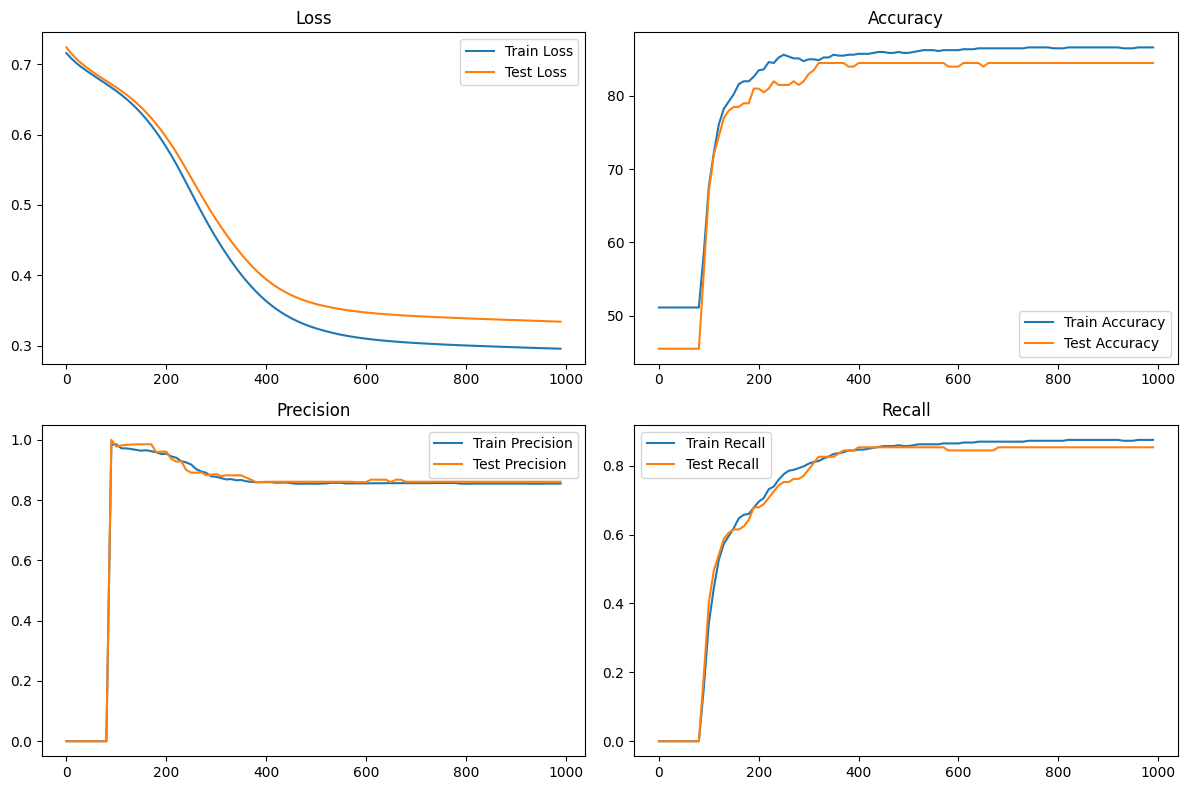

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()


axs[0].plot(epoch_counts, train_loss_list, label='Train Loss')
axs[0].plot(epoch_counts, test_loss_list, label='Test Loss')
axs[0].set_title("Loss")
axs[0].legend()


axs[1].plot(epoch_counts, train_accuracy_list, label='Train Accuracy')
axs[1].plot(epoch_counts, test_accuracy_list, label='Test Accuracy')
axs[1].set_title("Accuracy")
axs[1].legend()


axs[2].plot(epoch_counts, train_precision_list, label='Train Precision')
axs[2].plot(epoch_counts, test_precision_list, label='Test Precision')
axs[2].set_title("Precision")
axs[2].legend()


axs[3].plot(epoch_counts, train_recall_list, label='Train Recall')
axs[3].plot(epoch_counts, test_recall_list, label='Test Recall')
axs[3].set_title("Recall")
axs[3].legend()

plt.tight_layout()
plt.show()


In [11]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "02_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\02_pytorch_workflow_model_0.pth


In [12]:
loaded_model_0 = MoonModel().to(device)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_logits = loaded_model_0(X_test).squeeze()
    loaded_model_preds = torch.round(torch.sigmoid(loaded_model_logits))
   
pd.Series((y_test_preds == loaded_model_preds).cpu().numpy()).value_counts()

True    200
Name: count, dtype: int64